In [12]:
import numpy
import scipy.io
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import cm

C = 10

In [52]:
def task1_1(X, Y):
    # Input:
    #  X : N-by-D data matrix (np.float64)
    #  Y : N-by-1 label vector (np.int32)
    # Variables to save
    #  S : D-by-D covariance matrix (np.float64) to save as 't1_S.mat'
    #  R : D-by-D correlation matrix (np.float64) to save as 't1_R.mat'
    
    N = len(X)
    D = len(X[0])
    
    x_bar = X.sum((0,))/N
    
    X_st = [numpy.asmatrix(x-x_bar) for x in X]
    S = sum([(x.transpose()@x).A for x in X_st])/N
    scipy.io.savemat('t1_S.mat', dict(S=S))
    
    sqrtd_vrns = [numpy.sqrt(S.item(i,i)) for i in range(D)]
    
    R = [
        S[i] / sqrtd_vrns / sqrtd_vrns[i]
        for i in range(D)
    ]
    
    scipy.io.savemat('t1_R.mat', dict(R=R))

In [36]:
def task1_2():
    mat = scipy.io.loadmat('dset.mat')
    task1_1(mat['X'], mat['Y_species'])
    R = scipy.io.loadmat('t1_R.mat')['R']
    
    # first graph
    cax = plt.matshow(R, interpolation='nearest')
    plt.colorbar(cax)

    D = len(R)
    #print([(i,j) for i in range (D) for j in range(D) if i!=j and (R.item(i,j)>0.5)])
    plt.savefig('task1_2_covm.png')
    plt.show()
    
    # second graph
    def step_f(x):
        if x > 0.5:
            return 1
        elif x < -0.5:
            return -1
        else:
            return 0

    R_selected = numpy.vectorize(step_f)(R)
    fig = plt.figure()
    cax = plt.matshow(R_selected, interpolation='nearest')
    plt.colorbar(cax)
    plt.savefig('task1_2_covm_stepped.png')
    plt.show()

#task1_2()

In [25]:
def listToColV(li):
    return numpy.asarray(li).reshape(-1,1)

def task1_3(Cov):
    # Input:
    #  Cov : D-by-D covariance matrix (np.float64)
    # Variales to save:
    #  EVecs : D-by-D matrix of column vectors of eigen vectors (np.float64)  
    #  EVals : D-by-1 vector of eigen values (np.float64)  
    #  Cumvar : D-by-1 vector of cumulative variance (np.float64)  
    #  MinDims : 4-by-1 vector (np.int32)  

    D = len(Cov)
    EVals_orig, EVecs_mat = numpy.linalg.eigh(Cov)

    sorted_evals = sorted(zip(EVals_orig, range(D)), reverse=True)
    EVals = [EVals_orig[i] for (_,i) in sorted_evals]

    def norm_EV(v):
        if v.item(0) > 0:
            return v
        else:
            return -v
    
    # reordering the Eigenvectors so that they match the sorted Eigenvalues, normalising
    EVecs = numpy.column_stack([norm_EV(EVecs_mat[:,i]) for (_,i) in sorted_evals])
    
    scipy.io.savemat('t1_EVecs.mat', dict(EVecs=EVecs))
    scipy.io.savemat('t1_EVals.mat', dict(EVals=listToColV(EVals)))

    Cumvar = [sum(EVals[:(i+1)]) for i in range(D)]
    scipy.io.savemat('t1_Cumvar.mat', dict(Cumvar=listToColV(Cumvar)))

    def calcMinDims(variance_ratio):
        total_var = Cumvar[-1]
        indexed_Cumvar = zip(Cumvar, range(D))
        return min(
            [i+1 for (cv, i) in indexed_Cumvar if cv >= total_var * variance_ratio]
        )

    MinDims = [numpy.int32(calcMinDims(perc/100)) for perc in [70,80,90,95]]
    scipy.io.savemat('t1_MinDims.mat', dict(MinDims=listToColV(MinDims)))

In [37]:
def task1_3b():
    S = scipy.io.loadmat('t1_S.mat')['S']
    task1_3(S)
    
    Cumvar_mat = scipy.io.loadmat('t1_Cumvar.mat')['Cumvar']
    Cumvar = [Cumvar_mat.item(i,0) for i in range(len(Cumvar_mat))]
    
    plt.bar(range(1, len(Cumvar)+1), Cumvar)
    fig = plt.axes()
    fig.set_ylabel('Variance')
    fig.set_xlabel('Dimensions in PCA')
    plt.savefig('task1_3b_cumvar_graph.png')
    plt.show()
    
#task1_3b()

/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


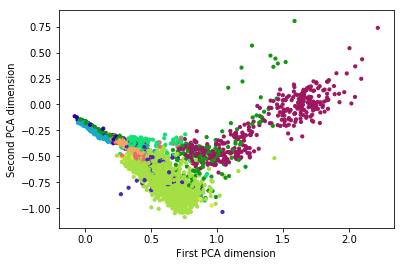

In [39]:
def task_1_3_c():
    X = mat['X']
    eigenvecs_cols = scipy.io.loadmat('t1_EVecs.mat')['EVecs']
    u = eigenvecs_cols[:,0].reshape(-1, 1)
    v = eigenvecs_cols[:,1].reshape(-1, 1)
    Y_n = numpy.matmul(X, u)
    Z_n = numpy.matmul(X, v)

    Y_species = mat['Y_species']
    class_colours = (numpy.random.rand(C,3)**1.5).tolist()
    colour_by_index = [class_colours[Y_species.item(i,0)-1] for i in range(len(Y_n))]
    plt.scatter([y[0] for y in Y_n], 
                [z[0] for z in Z_n],
                c=colour_by_index,
                s=10
    )

    fig = plt.axes()
    fig.set_xlabel('First PCA dimension')
    fig.set_ylabel('Second PCA dimension')
    plt.savefig('task1_3c_scatter_classes.png')

    plt.show()

task_1_3_c()

In [41]:
def calculatePMap(Y, Kfolds):
    class_freq = Counter(Y.T.tolist()[0])
    
    def Mc(class_num):
        return class_freq[class_num]//Kfolds
    
    # what partition to assign to the next instance of a certain class
    current_class_partition = dict((i,1) for i in range(1,C+1))
    # when to switch to the next partition for a certain class
    current_class_left = dict((i, Mc(i)) for i in range(1, C+1))
    
    PMap = []
    
    for i in range(len(Y)):
        class_num = Y.item(i,0) 
        
        # switch to next partition if no samples left
        if current_class_left[class_num] == 0 and \
                current_class_partition[class_num] != Kfolds:
            
            current_class_partition[class_num] += 1
            current_class_left[class_num] = Mc(class_num)
        
        PMap.append(current_class_partition[class_num])
        current_class_left[class_num] -= 1
    
    return PMap

# MLEs for the full covariance matrix model
def full_covmat_estimate_parameters_for_class(X, class_samples):
    n = len(class_samples)
    
    # MLE of the mean vector 
    mu_mle = sum([X[i] for i in class_samples]) / n
    
    # X vectors, standardized and converted to matrices
    X_st = [numpy.asmatrix(X[i]-mu_mle) for i in class_samples]
    
    # different order in matrix multiplication 
    #  because x-s are row and not column vectors initially
    Eps_mle = sum([(x.transpose()@x).A for x in X_st]) / n

    return mu_mle, Eps_mle


# returns the mean vectors and regularised Epsilons (covariance matrices)
def estimate_parameters_for_all_classes(X, Y, training_samples, CovKind):    
    mu_hats, Eps_regs = [], []
    
    for c in range(1, C+1):    
        class_samples = [i for i in training_samples if Y.item(i,0) == c]

        mu_hat, Eps_hat = full_covmat_estimate_parameters_for_class(X, class_samples)
        mu_hats.append(mu_hat)

        if CovKind == 2:
            # zero everything except the diagonal
            #  (Numpy has a bit of an... interesting way of doing this)
            Eps_hat = numpy.diag(numpy.diag(Eps_hat))

        # regularising (doesn't matter if we do that now or at the end if CovKind == 3)
        Eps_reg = Eps_hat + numpy.identity(len(Eps_hat))*epsilon
        Eps_regs.append(Eps_reg)

    if CovKind == 3:
        # the shared covariance matrix is the mean covariance matrix
        Eps = sum(Eps_regs)/C
        Eps_regs = [Eps for _ in Eps_regs]
        
    return mu_hats, Eps_regs


def generate_confusion_matrix(Y, classifications, test_samples):
    confusion_matrix = numpy.ndarray((C,C))
    confusion_matrix.fill(0.0)

    for i in test_samples:
        class_real = Y.item(i, 0)
        class_predicted = classifications[i]
        coords = (class_real-1, class_predicted-1)
        confusion_matrix.itemset(coords, confusion_matrix.item(coords)+1)
        
    return confusion_matrix

def task1_mgc_cv(X, Y, CovKind, epsilon, Kfolds):
    # Input:
    #  X : N-by-D matrix of feature vectors (np.float64)
    #  Y : N-by-1 label vector (np.int32)
    #  CovKind : scalar (np.int32)
    #  epsilon : scalar (np.float64)
    #  Kfolds  : scalar (np.int32)
    #
    # Variables to save:
    #  PMap   : N-by-1 vector (np.ndarray) of partition numbers (np.int32)
    #  Ms     : C-by-D matrix (np.ndarray) of mean vectors (np.float64)
    #  Covs   : C-by-D-by-D array (np.ndarray) of covariance matrices (np.float64)
    #  CM     : C-by-C confusion matrix (np.ndarray) (np.float64)
    
    PMap = calculatePMap(Y, Kfolds)
    scipy.io.savemat(f't1_mgc_{Kfolds}cv_PMap.mat', dict(PMap=listToColV(PMap)))  
    
    # confusion matrices for each partition, divided by the number of its test samples
    freq_confusion_matrices = dict()
    
    for p in range(1, Kfolds+1):
        training_samples = [i for i in range(len(PMap)) if PMap[i] != p]
        test_samples = [i for i in range(len(PMap)) if PMap[i] == p]
        mu_hats, Eps_regs = estimate_parameters_for_all_classes(X, Y, training_samples)

        # save the MLEs for all classes
        scipy.io.savemat(f't1_mgc_{Kfolds}cv{p}_Ms.mat', dict(Ms=mu_hats))
        scipy.io.savemat(f't1_mgc_{Kfolds}cv{p}_ck{CovKind}_Covs.mat', dict(Covs=Eps_regs))
        
        # classification of test samples
        
        class_log_posteriors = [[] for i in range(len(X))]
        class_counts = Counter([Y.item(i,0) for i in test_samples])
        
        for c in range(1, C+1):
            mu, Eps = mu_hats[c-1], Eps_regs[c-1]
            
            log_prior = numpy.log(class_counts[c]/len(training_samples))
            log_det = numpy.linalg.slogdet(Eps)[1]
            
            for i in test_samples:
                x_r = X[i]-mu # row vector
                x = x_r.reshape(-1, 1) # column vector
                first_term = x_r @ numpy.linalg.inv(Eps) @ x
                log_posterior = (-1/2) * first_term - (1/2) * log_det + log_prior
                class_log_posteriors[i].append((log_posterior, c))
                
        
        classifications = [max(sample_posteriors, default=([],[]))[1]
                                    for sample_posteriors in class_log_posteriors]
        
        # once the classifications are computed, calculate the confusion matrix
        confusion_matrix = generate_confusion_matrix(Y, classifications, test_samples)
        freq_confusion_matrices[p] = confusion_matrix/len(test_samples)
        
        scipy.io.savemat(f't1_mgc_{Kfolds}cv{p}_ck{CovKind}_CM.mat', 
                         dict(CM=confusion_matrix))
    
    final_confusion_matrix = sum([cm for cm in freq_confusion_matrices.values()])/Kfolds
    scipy.io.savemat(f't1_mgc_{Kfolds}cv{Kfolds+1}_ck{CovKind}_CM.mat', 
                     dict(CM=final_confusion_matrix))    

In [57]:
def task_1_4_b():
    mat = scipy.io.loadmat('test_dset.mat')
    for CovKind in [1,2,3]:
        task1_mgc_cv(mat['X'], mat['Y_species'], CovKind, 0.01, 5)
        score = sum(numpy.diag(scipy.io.loadmat(f't1_mgc_5cv6_ck{CovKind}_CM.mat')['CM']))
        print(f'for CovKind={CovKind}, accuracy is {score}')

task_1_4_b()

for CovKind=1, accuracy is 0.6326061680953788
for CovKind=2, accuracy is 0.6096778007685486
for CovKind=3, accuracy is 0.6608444181692776


In [58]:
for CovKind in [1,2,3]:
    for j in [1,2,3,4,5,6]:
        testmat = scipy.io.loadmat(f't1_mgc_5cv{j}_ck{CovKind}_CM.mat')

        mat_kobiela = scipy.io.loadmat(f'/home/stas/Downloads/Learning kobiela/Learning/t1_mgc_5cv{j}_ck{CovKind}_CM.mat')
        diff = testmat['CM']-mat_kobiela['CM'] / (1000 if j == 6 else 1)
        print(diff.min(), diff.max())


-1.0 1.0
-1.0 1.0
-1.0 1.0
-1.0 1.0
-2.0 2.0
-0.000425522810129 0.000275358261898
0.0 0.0
-1.0 1.0
-2.0 2.0
-1.0 1.0
-2.0 2.0
-0.000445632574638 0.000364052123362
0.0 0.0
0.0 0.0
0.0 0.0
-1.0 1.0
-2.0 2.0
-0.000387273918613 0.00035774145236


In [10]:
def task_1_4_c():
    epsilons = []
    scores = []
    for epsilon in [0.8**i for i in range(1, 50)]:
        task1_mgc_cv(mat['X'], mat['Y_species'], 1, epsilon, 5)
        final_confusion_matrix = scipy.io.loadmat(f't1_mgc_5cv6_ck1_CM.mat')['CM']
        score = sum(numpy.diag(final_confusion_matrix))
        print(score)
        epsilons.append(epsilon)
        scores.append(score)
    
    # draw a plot
    fig, ax = plt.subplots()
    ax.scatter(epsilons, scores)
    plt.xscale('log')
    ax.set_xlim(1, 0.8**50)
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('Accuracy')
    plt.savefig('task1_4c_epsilons_accuracy.png')
    plt.show()

0.499533869886
0.50047954393
0.503323272971
0.512112676056
0.527541918176
0.537994634474
0.541321260899
0.5448759222
0.551287726358
0.645556673374
0.701807511737
0.733601609658
0.752357478203
0.773484238766
0.794154929577
0.822890677398
0.844265593561
0.864668008048
0.882964453387
0.895073775989
0.905036887995
0.912877263581
0.921180415828
0.924034205231
0.927122736419
0.931160295104
0.934714956405
0.941847753186
0.949439973172
0.956083165661
0.962498323273
0.965345405768
0.968192488263
0.971274312542
0.974590878605
0.978152246814
0.984329309188
0.98932260228
0.990513078471
0.991462105969
0.992414486922
0.992414486922
0.991938296445
0.991224010731
0.990985915493
0.991931589537
0.991462105969
0.991462105969
0.991462105969


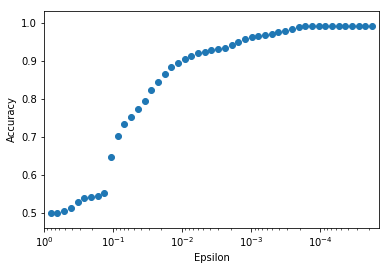